In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import statistics

def set_size(fraction_width=0.95, fraction_height=0.25):
    width_pt = 241.14749 # column width in pt
    height_pt = 626.0 # page height in pt

    fig_width_pt = width_pt * fraction_width
    fig_height_pt = height_pt * fraction_height
    inches_per_pt = 1 / 72.27

    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_height_pt * inches_per_pt

    return fig_width_in, fig_height_in

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# Disable grid by default
plt.rcParams['axes.grid'] = False
# Set default background color for the entire figure
# plt.rcParams['figure.facecolor'] = 'white'

# Set default background color for the plot area (axes)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.color'] = 'black'      # X-axis tick labels
plt.rcParams['ytick.color'] = 'black'      # Y-axis tick labels
plt.rcParams['axes.labelcolor'] = 'black'    # X and Y axis labels
plt.rcParams['axes.edgecolor'] = 'black'      # Edge

def create_dict():
    return {"Execution": [], "Optimization": []}

colors = {'ST-Decompose': 'blue', 'DP_CCP': 'blue', 'ResultDB':'green', 'ResultDB-Heuristic':'green', 'ResultDB-WC':'green', 'DP_Root': 'brown', 'TD_Root': 'brown', 'DP_Fold': 'red', 'DP_Fold-Greedy': 'orange', 'DP_Hybrid': 'violet', 'DP_ResultDB': 'violet', 'DPTD_ResultDB': 'pink'}
alg_to_latex = {'DP_CCP': r'ResultDB$_{\text{Decompose}}$', 'ResultDB-Heuristic': r'ResultDB$_{\text{Semi-Join}}$', 'ResultDB-WC': r'ResultDB$_{\text{Semi-Join}}$', 'ResultDB': r'DP$_{\text{Decompose}}$', 'DP_Root': r'TD$_{\text{Root}}$', 'TD_Root': r'TD$_{\text{Root}}$', 'DP_Fold': r'DP$_{\text{Fold}}$', 'DP_Fold-Greedy': r'DP$_{\text{Fold-Greedy}}$', 'ST-Decompose': r'ResultDB$_{\text{Decompose}}$', 'DP_Hybrid': r'DP$_{\text{ResultDB}}$', 'DP_ResultDB': r'DP$_{\text{ResultDB}}$', 'DPTD_ResultDB': r'DPTD$_{\text{ResultDB}}$'}
markers = {'DP_CCP': r'o', 'ResultDB-Heuristic': r's', 'ResultDB-WC': r's', 'ResultDB': r's', 'DP_Root': r'*', 'TD_Root': r'*', 'DP_Fold': r'p', 'DP_Fold-Greedy': r'P', 'ST-Decompose': r'o', 'DP_Hybrid': r'h', 'DP_ResultDB': r'h', 'DPTD_ResultDB': r'h'}

# Result Set Sizes

{'ST-Decompose': {'Execution': [71.967, 108.119, 146.024, 479.729, 1160.82, 283.664, 1017.44, 828.176], 'Optimization': []}, 'ResultDB-Heuristic': {'Execution': [1203.8, 1589.8, 200.56, 834.079, 5382.67, 814.391, 2486.23, 7379.47], 'Optimization': []}, 'DP_Fold': {'Execution': [741.195, 1072.55, 199.546, 596.53, 1244.83, 315.622, 1603.7, 5545.74], 'Optimization': []}, 'DP_Fold-Greedy': {'Execution': [744.322, 1084.81, 202.773, 622.8824999999999, 1238.75, 315.375, 1554.42, 5527.89], 'Optimization': []}, 'DP_Hybrid': {'Execution': [76.603, 107.867, 146.816, 521.713, 1161.82, 307.836, 953.775, 817.386], 'Optimization': []}}


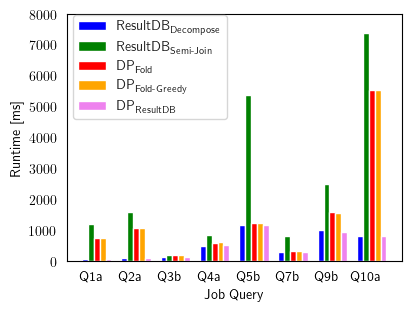

In [7]:
 # construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }

algorithm_times = {
    'ST-Decompose': create_dict(),
    'ResultDB-Heuristic': create_dict(),
    'DP_Fold': create_dict(),
    'DP_Fold-Greedy': create_dict(),
    'DP_Hybrid': create_dict(),
}
# ensure that `queries` is sorted!
queries = [
    'Q1a',
    'Q2a',
    'Q3b',
    'Q4a',
    'Q5b',
    'Q7b',
    'Q9b',
    'Q10a'
]
# data = pd.read_csv('./mutable-internal/evaluation/job/cycle_results.csv')
data = pd.read_csv('./mutable-internal/evaluation/job_new/results.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'case', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['experiment'] == query]

    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "Decompose" in algorithm:
            algorithm_times['ST-Decompose'][key].append(time)
        elif "Heuristic" in algorithm:
            algorithm_times['ResultDB-Heuristic'][key].append(time)
        elif "Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'][key].append(time)
        elif "Fold" in algorithm:
            algorithm_times['DP_Fold'][key].append(time)
        elif "ResultDB" in algorithm:
            algorithm_times['DP_Hybrid'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"
# display(algorithm_times)
            
# plot data
x = np.arange(len(queries))  # the label locations
print(algorithm_times)
width = 0.15  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm], color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Job Query')
ax.set_xticks(x + width, queries)
ax.set_ylim(0, 8000)
# ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.15, 0.99), loc='upper left')

fig.savefig('job-standardbenchmarks.pdf')

# Star Benchmarks

{'DP_CCP': [0.0365, 0.1785, 3.541, 1123.455], 'ResultDB-Heuristic': [0.017, 0.05, 0.269, 0.1365], 'DP_Root': [0.022, 0.059, 0.278, 0.159], 'DP_ResultDB': [0.0465, 0.19, 3.3945, 1120.9]}
TD_Root 1.1724175824175824
ResultDB 1.0310757679575562


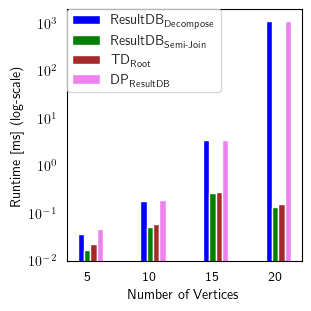

In [32]:
 # construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }
algorithm_times = {
    'DP_CCP': [],
    'ResultDB-Heuristic': [],
    'DP_Root': [],
    'DP_ResultDB': []
}
# ensure that `queries` is sorted!
sizes = [5, 10, 15, 20]
data = pd.read_csv('./mutable-internal/evaluation/enumeration_time/star.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "DP_Root" in algorithm:
            algorithm_times['DP_Root'].append(execution_time)
        elif "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-Heuristic'].append(execution_time)
        elif "DP_CCP" in algorithm:
            algorithm_times['DP_CCP'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
            
# display(algorithm_times)
print(algorithm_times)    

ov = []
for i in range(len(algorithm_times['DP_Root'])):
    ov_i = algorithm_times['DP_Root'][i] / algorithm_times['ResultDB-Heuristic'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print("TD_Root", median_value)
ov = []
for i in range(len(algorithm_times['DP_Root'])):
    ov_i = algorithm_times['DP_ResultDB'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print("ResultDB", median_value)
# plot data
x = np.arange(len(sizes))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(3,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
#ax.set_ylim(0, 0.2)
ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.18, 1.01), loc='upper left')

fig.savefig('star-benchmarks.pdf')


## Chain Queries

{'DP_CCP': [0.026, 0.093, 0.389, 0.473], 'ResultDB-Heuristic': [0.017, 0.0515, 0.2715, 0.142], 'DP_Root': [0.0205, 0.057, 0.2755, 0.149], 'DP_ResultDB': [0.0325, 0.101, 0.399, 0.483]}
1.078045945576371
ResultDB 1.05586422312519


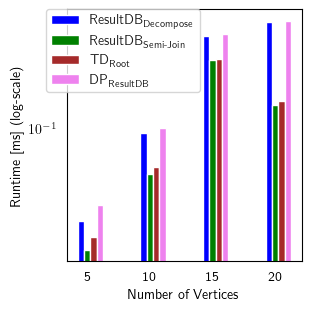

In [35]:
 # construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }
algorithm_times = {
    'DP_CCP': [],
    'ResultDB-Heuristic': [],
    'DP_Root': [],
    'DP_ResultDB': []
}
# ensure that `queries` is sorted!
sizes = [5, 10, 15, 20]
data = pd.read_csv('./mutable-internal/evaluation/enumeration_time/chain.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "DP_Root" in algorithm:
            algorithm_times['DP_Root'].append(execution_time)
        elif "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-Heuristic'].append(execution_time)
        elif "DP_CCP" in algorithm:
            algorithm_times['DP_CCP'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
            
# display(algorithm_times)
print(algorithm_times)    

ov = []
for i in range(len(algorithm_times['DP_Root'])):
    ov_i = algorithm_times['DP_Root'][i] / algorithm_times['ResultDB-Heuristic'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
ov = []
for i in range(len(algorithm_times['DP_Root'])):
    ov_i = algorithm_times['DP_ResultDB'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print("ResultDB", median_value)
# plot data
x = np.arange(len(sizes))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(3,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
#ax.set_ylim(0, 1)
ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.11, 1.01), loc='upper left')

fig.savefig('chain-benchmarks.pdf')

 # Cycle Benchmarks

{'DP_CCP': [0.029, 0.103, 0.4225, 0.6605000000000001], 'ResultDB-Heuristic': [0.031, 0.098, 0.311, 0.362], 'DP_Fold': [0.038, 0.122, 0.4475, 0.7184999999999999], 'DP_Fold-Greedy': [0.039, 0.123, 0.452, 0.723], 'DP_ResultDB': [0.0415, 0.1265, 0.452, 0.7235]}
1.136139141427133
1.1444000205787024
1.1617688129763417


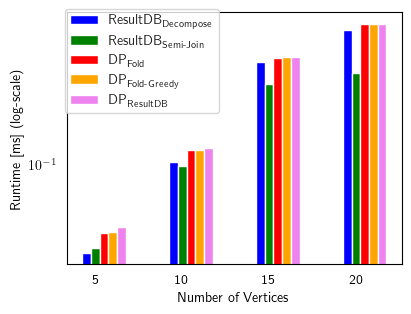

In [36]:
 # construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }
algorithm_times = {
    'DP_CCP': [],
    'ResultDB-Heuristic': [],
    'DP_Fold': [],
    'DP_Fold-Greedy': [],
    'DP_ResultDB': []
}
# ensure that `queries` is sorted!
sizes = [5, 10, 15, 20]
data = pd.read_csv('./mutable-internal/evaluation/enumeration_time/cycle.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'].append(execution_time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'].append(execution_time)
        elif "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-Heuristic'].append(execution_time)
        elif "DP_CCP" in algorithm:
            algorithm_times['DP_CCP'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
        else:
            assert False, f"experiment name: {name} does not match any of our algorithms"
print(algorithm_times)
# display(algorithm_times)
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_Fold'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_Fold-Greedy'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_ResultDB'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
# plot data
x = np.arange(len(sizes))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
#ax.set_ylim(0)
ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.13, 1.02), loc='upper left')

fig.savefig('cycle-benchmarks.pdf')

# Two-Vertex Cuts

{'DP_CCP': [0.035, 0.153, 1.3715000000000002, 36.969], 'ResultDB-Heuristic': [0.036500000000000005, 0.0995, 0.2365, 0.666], 'DP_Fold': [0.048, 0.179, 1.3505, 37.674], 'DP_Fold-Greedy': [0.039, 0.083, 0.136, 0.2125], 'DP_ResultDB': [0.0605, 0.188, 1.4465, 37.318]}
1.0945023360855068
0.32082258106791145
1.141721410887845


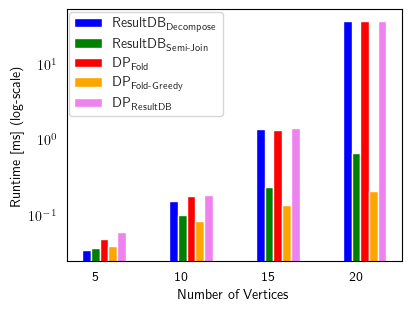

In [37]:
 # construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }
algorithm_times = {
    'DP_CCP': [],
    'ResultDB-Heuristic': [],
    'DP_Fold': [],
    'DP_Fold-Greedy': [],
    'DP_ResultDB': []
}
# ensure that `queries` is sorted!
sizes = [5, 10, 15, 20]
data = pd.read_csv('./mutable-internal/evaluation/enumeration_time/two_vertex_cuts.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'].append(execution_time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'].append(execution_time)
        elif "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-Heuristic'].append(execution_time)
        elif "DP_CCP" in algorithm:
            algorithm_times['DP_CCP'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
        else:
            assert False, f"experiment name: {name} does not match any of our algorithms"
# display(algorithm_times)
print(algorithm_times)      
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_Fold'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_Fold-Greedy'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_ResultDB'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
# plot data
x = np.arange(len(sizes))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
#ax.set_ylim(0, 1)
ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.14, 1.00), loc='upper left')

fig.savefig('two-vertex-cuts-benchmarks.pdf')

# Mixed

{'DP_CCP': [0.034, 0.13, 1.266, 35.247], 'ResultDB-Heuristic': [0.028, 0.0635, 0.14, 0.313], 'DP_Fold': [0.035, 0.092, 0.3735, 0.454], 'DP_Fold-Greedy': [0.034, 0.083, 0.1755, 0.208], 'DP_ResultDB': [0.053, 0.143, 1.2309999999999999, 36.034]}
0.501358002187386
0.3885435654393001
1.0611640707010523
1.0611640707010523


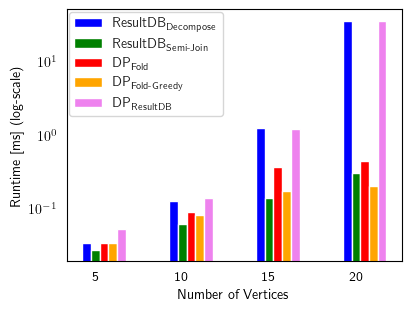

In [38]:
 # construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }
algorithm_times = {
    'DP_CCP': [],
    'ResultDB-Heuristic': [],
    'DP_Fold': [],
    'DP_Fold-Greedy': [],
    'DP_ResultDB': []
}
# ensure that `queries` is sorted!
sizes = [5, 10, 15, 20]
data = pd.read_csv('./mutable-internal/evaluation/enumeration_time/mixed.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for size in sizes:
    # Get Results for each query 
    size_data = data[data['case'] == size]

    for _, row in size_data.iterrows():
        algorithm = row['name']
        execution_time = row['time']
        if "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'].append(execution_time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'].append(execution_time)
        elif "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-Heuristic'].append(execution_time)
        elif "DP_CCP" in algorithm:
            algorithm_times['DP_CCP'].append(execution_time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'].append(execution_time)
        else:
            assert False, f"experiment name: {name} does not match any of our algorithms"
# display(algorithm_times)
print(algorithm_times)   
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_Fold'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_Fold-Greedy'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
ov = []
for i in range(len(algorithm_times['DP_Fold'])):
    ov_i = algorithm_times['DP_ResultDB'][i] / algorithm_times['DP_CCP'][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)
print(median_value)
# plot data
x = np.arange(len(sizes))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, time in algorithm_times.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, time, width, label=alg_to_latex[algorithm], color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, sizes)
#ax.set_ylim(0, 1)
ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.14, 1.00), loc='upper left')

fig.savefig('mixed.pdf')

# Large Joins 

## Cycles 

In [ ]:
 # construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }

algorithm_times = {
    'ResultDB-Heuristic': create_dict(),
    'DP_Fold': create_dict(),
    'DP_Fold-Greedy': create_dict(),
}
# ensure that `queries` is sorted!
queries = [
    'Q5',
    'Q6',
    'Q7',
    'Q8',
    'Q9'
]
data = pd.read_csv('./mutable-internal/evaluation/large_joins/cyclic.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'case', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['experiment'] == query]

    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "NoOpt" in algorithm:
            algorithm_times['ResultDB-Heuristic'][key].append(time)
        elif "NoGreedyCuts" in algorithm:
            algorithm_times['DP_Fold'][key].append(time)
        elif "GreedyCuts" in algorithm:
            algorithm_times['DP_Fold-Greedy'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"
# display(algorithm_times)
ov = []
for i in range(len(algorithm_times['DP_Fold-Greedy'])):
    ov_i = algorithm_times['DP_Fold-Greedy']["Execution"][i] / algorithm_times['ResultDB-Heuristic']["Execution"][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)            
# plot data
x = np.arange(len(queries))  # the label locations
print(algorithm_times)
width = 0.10  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(3,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm], color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, [s[1] for s in queries])
#ax.set_ylim(0, 500)
ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.17, 1.01), loc='upper left')

fig.savefig('large-joins-cyclic-benchmarks.pdf')

## Two Vertex Cuts

In [ ]:
 # construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
algorithm_times = {
    'ResultDB-Heuristic': create_dict(),
    'DP_Fold': create_dict(),
    'DP_Fold-Greedy': create_dict(),
}
# ensure that `queries` is sorted!
queries = [
    'Q5',
    'Q6',
    'Q7',
    'Q8',
    'Q9'
]
data = pd.read_csv('./mutable-internal/evaluation/large_joins/two_vertex_cuts.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'case', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['experiment'] == query]

    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "NoOpt" in algorithm:
            algorithm_times['ResultDB-Heuristic'][key].append(time)
        elif "NoGreedyCuts" in algorithm:
            algorithm_times['DP_Fold'][key].append(time)
        elif "GreedyCuts" in algorithm:
            algorithm_times['DP_Fold-Greedy'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"
# display(algorithm_times)
ov = []
for i in range(len(algorithm_times['DP_Fold-Greedy'])):
    ov_i = algorithm_times['DP_Fold-Greedy']["Execution"][i] / algorithm_times['ResultDB-Heuristic']["Execution"][i]
    ov.append(ov_i)
median_value = statistics.median(ov)
print(median_value)  
# plot data
x = np.arange(len(queries))  # the label locations
print(algorithm_times)
width = 0.10  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(3,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm],  color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms] (log-scale)')
ax.set_xlabel('Number of Vertices')
ax.set_xticks(x + width, [s[1] for s in queries])
#ax.set_ylim(0, 100)
ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.17, 1.01), loc='upper left')

fig.savefig('large-joins-two-vertex-cuts-benchmarks.pdf')

In [3]:
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
random.seed(42)
a_list = [1.1, 1.2, 1.5, 2, 3, 4, 5]
for a_ in a_list:
    print(f"###{a_}###")
    x = random.zipf(a=a_, size=80)
    for i in range(1, 5):  
        print(f"{4 - i}:{80 - len(x[x==i])}")

###1.1###
3:69
2:78
1:77
0:79
###1.2###
3:61
2:73
1:80
0:79
###1.5###
3:41
2:73
1:74
0:76
###2###
3:25
2:67
1:75
0:77
###3###
3:10
2:73
1:78
0:79
###4###
3:9
2:75
1:80
0:78
###5###
3:5
2:75
1:80
0:80


1.0015908484430527
{'ResultDB-WC': {'Execution': [14987.4, 13653.1, 6482.32, 2705.38, 2965.3, 4115.97, 3111.8], 'Optimization': []}, 'TD_Root': {'Execution': [15177.0, 13442.4, 6956.65, 2969.76, 3401.01, 4103.24, 2766.75], 'Optimization': []}, 'DP_ResultDB': {'Execution': [15297.3, 13275.6, 6786.77, 2830.21, 2261.2, 2861.58, 1848.82], 'Optimization': []}, 'ST-Decompose': {'Execution': [24973.9, 21901.0, 12344.0, 953.308, 1840.43, 3557.21, 1853.67], 'Optimization': []}}


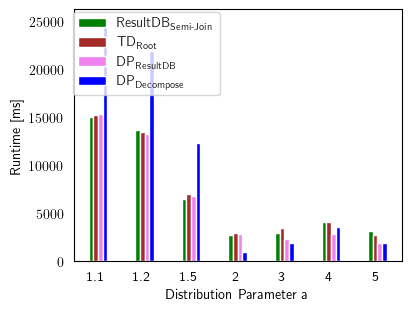

In [2]:
# construct the following dictionary:
# {
#   'Single-Table': [q4_time, q5_time, ...]
#   'Single-Table + Denom': [q4_time, q5_time, ...]
#   'Result-DB': [q4_time, q5_time, ...]
# }

algorithm_times = {
    'ResultDB-WC': create_dict(),
    'TD_Root': create_dict(),
    "DP_ResultDB": create_dict(),
    "ST-Decompose": create_dict()
}
# ensure that `queries` is sorted!
queries = [
    1.1,
    1.2,
    1.5,
    2,
    3,
    4,
    5
]
data = pd.read_csv('./mutable-internal/evaluation/star_schema/results.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['case'] == query]
    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-WC'][key].append(time)
        elif "TD_Root" in algorithm:
            algorithm_times['TD_Root'][key].append(time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'][key].append(time)
        elif "ResultDB-Decompose" in algorithm:
            algorithm_times['ST-Decompose'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"
# display(algorithm_times)
ov = []
for i in range(len(algorithm_times['TD_Root'])):
    ov_i = algorithm_times['ResultDB-WC']["Execution"][i] / algorithm_times['TD_Root']["Execution"][i]
    ov.append(ov_i)
median_value = statistics.median(ov)  
print(median_value)
# plot data
x = np.arange(len(queries))  # the label locations
print(algorithm_times)
width = 0.10  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm],  color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Distribution Parameter a')
ax.set_xticks(x + width, queries)
#ax.set_ylim(0, 7000)
#ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.15, 1), loc='upper left')

fig.savefig('star_schema-benchmarks.pdf')

1.1160007126184652
{'ResultDB-WC': {'Execution': [844.644, 983.433, 1550.52, 1621.13, 2220.96], 'Optimization': []}, 'ST-Decompose': {'Execution': [90.357, 672.628, 2752.72, 4974.35, 7334.91], 'Optimization': []}, 'TD_Root': {'Execution': [775.784, 860.216, 1035.11, 1350.34, 1858.99], 'Optimization': []}, 'DP_ResultDB': {'Execution': [94.592, 692.991, 1068.98, 1364.87, 1827.76], 'Optimization': []}}


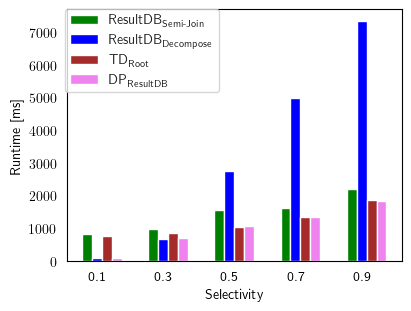

In [39]:
algorithm_times = {
    'ResultDB-WC': create_dict(),
    "ST-Decompose": create_dict(),
    'TD_Root': create_dict(),
    "DP_ResultDB": create_dict(),
}
# ensure that `queries` is sorted!
queries = list(reversed([
  #  0,
    1,
  #  2,
    3,
  #  4,
    5,
  #  6,
    7,
  #  8,
    9,
]))
data = pd.read_csv('./mutable-internal/evaluation/chain_schema/results.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['case'] == query]
    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-WC'][key].append(time)
        elif "TD_Root" in algorithm:
            algorithm_times['TD_Root'][key].append(time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'][key].append(time)
        elif "ResultDB-Decompose" in algorithm:
            algorithm_times['ST-Decompose'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"
# display(algorithm_times)
ov = []
for i in range(len(algorithm_times['TD_Root'])):
    ov_i = algorithm_times['ResultDB-WC']["Execution"][i] / algorithm_times['TD_Root']["Execution"][i]
    ov.append(ov_i)
median_value = statistics.median(ov)  
print(median_value)
# plot data
x = np.arange(len(queries))  # the label locations
print(algorithm_times)
width = 0.15  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm],  color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Selectivity')
ax.set_xticks(x + width, list(reversed([0.9, 0.7, 0.5, 0.3, 0.1])))
#ax.set_ylim(0, 7000)
#ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.13, 1.01), loc='upper left')

fig.savefig('chain_schema-benchmarks.pdf')

9
7
5
3
1
{'ResultDB-WC': {'Execution': [1123.73, 3625.83, 5973.08, 8359.28, 11523.1], 'Optimization': []}, 'ST-Decompose': {'Execution': [1042.92, 3778.14, 6104.15, 8029.65, 11012.85], 'Optimization': []}, 'DP_Fold': {'Execution': [398.08, 1110.41, 1617.08, 2360.26, 2808.29], 'Optimization': []}, 'DP_Fold-Greedy': {'Execution': [361.322, 1548.93, 1666.75, 2322.61, 2751.58], 'Optimization': []}, 'DP_ResultDB': {'Execution': [396.233, 1104.05, 1488.16, 2117.51, 2695.27], 'Optimization': []}}


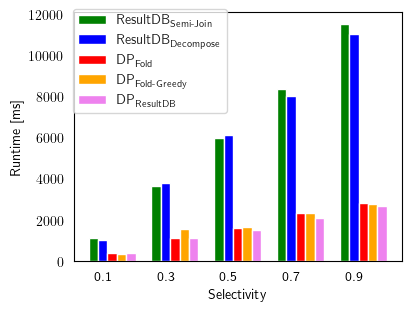

In [6]:
algorithm_times = {
    'ResultDB-WC': create_dict(),
    "ST-Decompose": create_dict(),
    'DP_Fold': create_dict(),
    'DP_Fold-Greedy': create_dict(),
    "DP_ResultDB": create_dict(),
}
# ensure that `queries` is sorted!
queries = list(reversed([
  #  0,
    1,
  #  2,
    3,
  #  4,
    5,
   # 6,
    7,
   # 8,
    9,
]))
data = pd.read_csv('./mutable-internal/evaluation/redundant_cycle/results_new.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    print(query)
    # Get Results for each query 
    query_data = data[data['case'] == query]
    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-WC'][key].append(time)
        elif "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'][key].append(time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'][key].append(time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'][key].append(time)
        elif "Decompose" in algorithm:
            algorithm_times['ST-Decompose'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"
# display(algorithm_times)
# plot data
x = np.arange(len(queries))  # the label locations
print(algorithm_times)
width = 0.15  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm],  color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Selectivity')
ax.set_xticks(x + width, list(reversed([0.9, 0.7, 0.5, 0.3, 0.1])))
#ax.set_ylim(0, 7000)
#ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.15, 1.01), loc='upper left')

fig.savefig('cycle_schema-benchmarks.pdf')

{'ResultDB-WC': {'Execution': [863.01, 2784.05, 4681.04, 6305.38, 11944.5], 'Optimization': []}, 'ST-Decompose': {'Execution': [917.951, 3816.74, 5389.25, 7097.57, 13657.4], 'Optimization': []}, 'DP_Fold': {'Execution': [335.563, 998.155, 1540.16, 1967.66, 3231.07], 'Optimization': []}, 'DP_Fold-Greedy': {'Execution': [350.356, 864.929, 1328.71, 1766.33, 3138.8], 'Optimization': []}, 'DP_ResultDB': {'Execution': [337.69, 768.739, 1205.3, 1569.74, 2654.74], 'Optimization': []}}


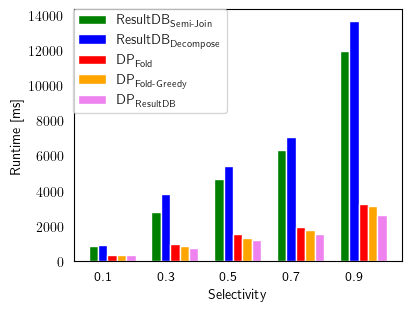

In [41]:
algorithm_times = {
    'ResultDB-WC': create_dict(),
    "ST-Decompose": create_dict(),
    'DP_Fold': create_dict(),
    'DP_Fold-Greedy': create_dict(),
    "DP_ResultDB": create_dict(),
}
# ensure that `queries` is sorted!
queries = list(reversed([
#    0,
    1,
 #   2,
    3,
  #  4,
    5,
   # 6,
    7,
  #  8,
    9,
]))
data = pd.read_csv('./mutable-internal/evaluation/redundant_tvc/results.csv')
data = (data.groupby(by=['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'name', 'config', 'case',], as_index=False)
                .median()
                .drop(['commit', 'date', 'version', 'suite', 'benchmark', 'experiment', 'runid'], axis=1)
        )
num_queries = 0
for query in queries:
    # Get Results for each query 
    query_data = data[data['case'] == query]
    for _, row in query_data.iterrows():
        key = "Execution"
        if 'Optimization' in row['config']:
            key = "Optimization"
        algorithm = row['name']
        time = row['time']
        if "ResultDB-Heuristic" in algorithm:
            algorithm_times['ResultDB-WC'][key].append(time)
        elif "DP_Fold-Greedy" in algorithm:
            algorithm_times['DP_Fold-Greedy'][key].append(time)
        elif "DP_Fold" in algorithm:
            algorithm_times['DP_Fold'][key].append(time)
        elif "DP_ResultDB" in algorithm:
            algorithm_times['DP_ResultDB'][key].append(time)
        elif "Decompose" in algorithm:
            algorithm_times['ST-Decompose'][key].append(time)
        else:
            assert False, f"experiment name: {algorithm} does not match any of our algorithms"
# display(algorithm_times)
# plot data
x = np.arange(len(queries))  # the label locations
print(algorithm_times)
width = 0.15  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(4,3))
for algorithm, times in algorithm_times.items():
    offset = width * multiplier
    ax.bar(x + offset, times["Execution"], width, label=alg_to_latex[algorithm],  color=colors[algorithm])
    # ax.bar_label(rects, padding=3, size=8)
    multiplier += 1

ax.set_ylabel('Runtime [ms]')
ax.set_xlabel('Selectivity')
ax.set_xticks(x + width, list(reversed([0.9, 0.7, 0.5, 0.3, 0.1])))
#ax.set_ylim(0, 7000)
#ax.set_yscale('log')
# fig.legend()
fig.legend(bbox_to_anchor=(0.15, 1.01), loc='upper left')

fig.savefig('tvc_schema-benchmarks.pdf')